<a href="https://colab.research.google.com/github/ShioTatsu-Japan/FizzBuzz/blob/main/APM466_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import requests
import pandas as pd
import numpy as np
import time
import random
import matplotlib.pyplot as plt
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Fundamental Questions

Question 2:

In [15]:
## manually choose the 10 bonds according to the criteria I listed in the form of bullet points in the pdf file

# Empirical Questions
Question 4:

In [16]:
df = pd.read_csv("/content/drive/My Drive/10Bonds.csv") # read csv file

df["Maturity Date"] = pd.to_datetime(df["Maturity Date"])
df["Coupon"] = df["Coupon"].str.rstrip('%').astype(float) / 100.0

FACE_VALUE = 100.0
FREQ = 2  # because semiannual

part a

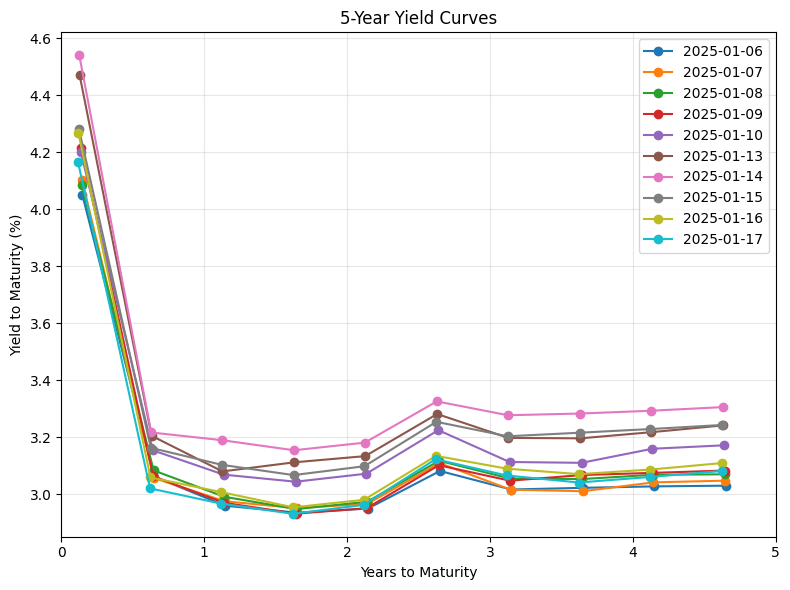

In [17]:
date_cols = [
    "2025-01-06", "2025-01-07", "2025-01-08", "2025-01-09",
    "2025-01-10", "2025-01-13", "2025-01-14", "2025-01-15",
    "2025-01-16", "2025-01-17"
]

def bond_price(yield_annual, coupon_rate, periods, freq=2, face_value=100.0):
    coupon_per_period = coupon_rate * face_value / freq
    price = 0.0

    n_full = int(np.floor(periods))
    frac = periods - n_full

    for t in range(1, n_full + 1):
        price += coupon_per_period / ((1.0 + yield_annual/freq) ** t)

    if frac > 1e-8:
        t_float = n_full + frac
        price += coupon_per_period / ((1.0 + yield_annual/freq) ** t_float)
        price += face_value      / ((1.0 + yield_annual/freq) ** t_float)
    else:
        price += face_value / ((1.0 + yield_annual/freq) ** n_full)

    return price


def compute_ytm(bond_market_price, coupon_rate, years_to_maturity,
                freq=2, face_value=100.0, tol=1e-7, max_iter=1000):
    periods = years_to_maturity * freq

    def f(y):
        return bond_price(y, coupon_rate, periods, freq, face_value) - bond_market_price

    lower, upper = 0.0, 1.0

    for _ in range(max_iter):
        mid = (lower + upper) / 2.0
        val_mid = f(mid)
        val_low = f(lower)
        if abs(val_mid) < tol:
            return mid
        if val_mid * val_low < 0:
            upper = mid
        else:
            lower = mid

    return (lower + upper) / 2.0


def years_between(d1, d2):
    return (d2 - d1).days / 365.25


def calculate_accrued_interest(settlement_date, issue_date, maturity_date,
                               coupon_rate, freq=2, face_value=100.0):
    if settlement_date <= issue_date or settlement_date >= maturity_date:
        return 0.0

    total_years = (settlement_date - issue_date).days / 365.25
    if total_years < 0:
        return 0.0

    n_coupons_since_issue = freq * total_years
    n_full_coupons = int(np.floor(n_coupons_since_issue))
    fraction_of_period = n_coupons_since_issue - n_full_coupons

    accrued = coupon_rate * face_value / freq * fraction_of_period
    return accrued

daily_curves = {}
all_rows = []

for date_str in date_cols:
    settlement_date = pd.to_datetime(date_str)
    row_dict = {"Date": date_str}

    tm_list = []
    ytm_list = []

    for i in range(len(df)):
        bond_label = f"Bond{i+1}"
        bond_info = df.iloc[i]

        clean_price = bond_info[date_str]
        if pd.isna(clean_price):
            row_dict[bond_label] = np.nan
            continue

        mat_date = bond_info["Maturity Date"]
        T = years_between(settlement_date, mat_date)
        if T <= 0:
            row_dict[bond_label] = np.nan
            continue

        c = bond_info["Coupon"]

        accrued_interest = calculate_accrued_interest(
            settlement_date = settlement_date,
            issue_date      = pd.to_datetime(bond_info["Issue Date"]),
            maturity_date   = mat_date,
            coupon_rate     = c,
            freq            = 2,
            face_value      = 100.0
        )
        dirty_price = clean_price + accrued_interest

        ytm_decimal = compute_ytm(
            bond_market_price = dirty_price,
            coupon_rate       = c,
            years_to_maturity = T,
            freq              = 2,
            face_value        = 100.0
        )

        row_dict[bond_label] = ytm_decimal * 100.0

        if T <= 5:
            tm_list.append(T)
            ytm_list.append(ytm_decimal * 100.0)

    all_rows.append(row_dict)

    sorted_pairs = sorted(zip(tm_list, ytm_list), key=lambda x: x[0])
    daily_curves[date_str] = sorted_pairs

plt.figure(figsize=(8,6))

for date_str, pairs in daily_curves.items():
    if not pairs:
        continue

    xvals, yvals = zip(*pairs)
    plt.plot(xvals, yvals, marker='o', linestyle='-', label=date_str)

plt.title("5-Year Yield Curves")
plt.xlabel("Years to Maturity")
plt.ylabel("Yield to Maturity (%)")
plt.xlim(0, 5)
plt.grid(True, alpha=0.3)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

df_wide = pd.DataFrame(all_rows).sort_values("Date") # this is for q5
df_wide.to_csv("/content/drive/MyDrive/bond_yields_by_date.csv", index=False)

part b

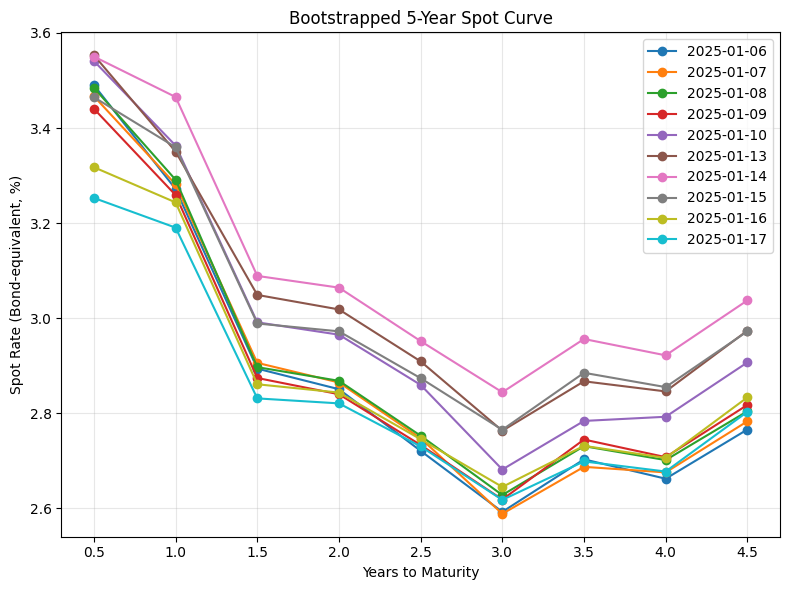

In [18]:
def calculate_accrued_interest(settlement_date, issue_date, maturity_date,
                               coupon_rate, freq=2, face_value=100.0):
    if settlement_date <= issue_date or settlement_date >= maturity_date:
        return 0.0

    total_years = (settlement_date - issue_date).days / 365.25
    if total_years < 0:
        return 0.0

    n_coupons_since_issue = freq * total_years
    n_full_coupons = int(np.floor(n_coupons_since_issue))
    fraction_of_period = n_coupons_since_issue - n_full_coupons

    accrued = (coupon_rate * face_value / freq) * fraction_of_period
    return accrued

def semiannual_periods_to_maturity(settlement_date, maturity_date):
    days_diff = (maturity_date - settlement_date).days
    semiannual_float = (days_diff / 365.25) * FREQ
    n = int(round(semiannual_float))
    return n

def per_period_coupon(annual_coupon_rate, face_value=FACE_VALUE, freq=FREQ):
    return (annual_coupon_rate * face_value) / freq

def price_theoretical(n, known_spots, C, face_value=FACE_VALUE):
    def bond_price_given_rn(r_n):
        pv = 0.0
        for t in range(1, n):
            r_t = known_spots[t]
            pv += C / ((1 + r_t)**t)
        pv += (C + face_value) / ((1 + r_n)**n)
        return pv
    return bond_price_given_rn

def solve_for_rn(bond_price_obs, n, known_spots, C, face_value=FACE_VALUE):
    f = price_theoretical(n, known_spots, C, face_value)

    def objective(r_n):
        return f(r_n) - bond_price_obs

    low, high = 0.0, 0.5
    for _ in range(100):
        mid = 0.5*(low + high)
        val_mid = objective(mid)
        if abs(val_mid) < 1e-8:
            return mid
        val_low = objective(low)
        if val_mid * val_low < 0:
            high = mid
        else:
            low = mid
    return 0.5*(low + high)

all_spot_curves = {}

for date_str in date_cols:
    settlement_date = pd.to_datetime(date_str)

    bond_list = []
    for _, row in df.iterrows():
        clean_price = row[date_str]
        if pd.isna(clean_price):
            continue

        mat_date = pd.to_datetime(row['Maturity Date'])
        n = semiannual_periods_to_maturity(settlement_date, mat_date)
        if n <= 0 or n > 10:
            continue

        c = per_period_coupon(row['Coupon'], FACE_VALUE, FREQ)

        issue_date = pd.to_datetime(row["Issue Date"])
        accrued_interest = calculate_accrued_interest(
            settlement_date=settlement_date,
            issue_date=issue_date,
            maturity_date=mat_date,
            coupon_rate=row['Coupon'],
            freq=FREQ,
            face_value=FACE_VALUE
        )
        dirty_price = clean_price + accrued_interest

        bond_list.append({
            'n': n,
            'price': dirty_price,
            'C': c
        })

    bond_list.sort(key=lambda b: b['n'])

    known_spots = {}
    spot_curve_list = []

    for bond_info in bond_list:
        n_i = bond_info['n']
        P_i = bond_info['price']
        C_i = bond_info['C']

        if n_i == 1:
            r_1 = (C_i + FACE_VALUE)/P_i - 1
            known_spots[1] = r_1
            spot_curve_list.append((1, r_1))
        else:
            missing_earlier = any(t not in known_spots for t in range(1, n_i))
            if missing_earlier:
                continue

            r_n = solve_for_rn(P_i, n_i, known_spots, C_i, FACE_VALUE)
            known_spots[n_i] = r_n
            spot_curve_list.append((n_i, r_n))

    all_spot_curves[date_str] = spot_curve_list

plt.figure(figsize=(8,6))

for date_str, curve_data in all_spot_curves.items():
    if not curve_data:
        continue

    curve_data_sorted = sorted(curve_data, key=lambda x: x[0])
    xvals = [item[0] / 2.0 for item in curve_data_sorted]
    yvals_annual = [(item[1] * FREQ) * 100.0 for item in curve_data_sorted]

    plt.plot(xvals, yvals_annual, marker='o', linestyle='-', label=date_str)

plt.title("Bootstrapped 5-Year Spot Curve")
plt.xlabel("Years to Maturity")
plt.ylabel("Spot Rate (Bond-equivalent, %)")
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

part c

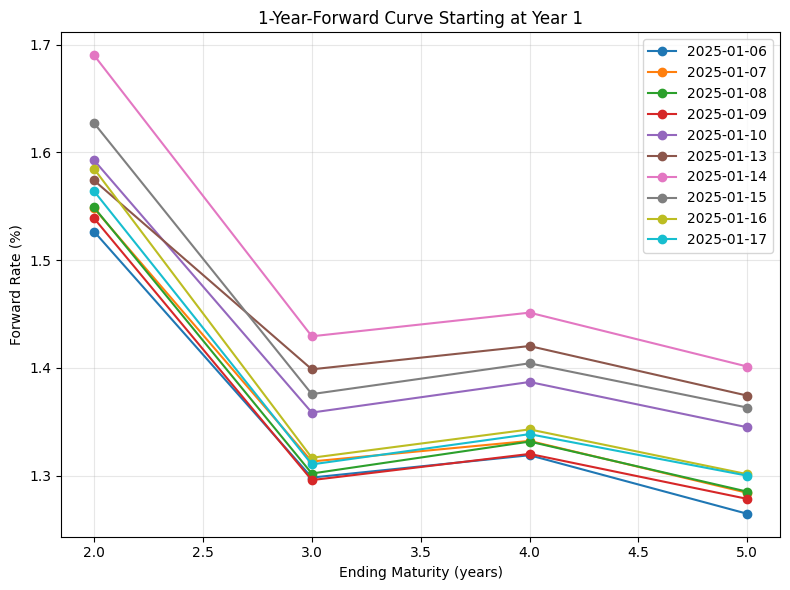

In [19]:
def compute_1yr_forward_curve(spot_curve):
    spot_dict = {m: y for (m, y) in spot_curve}

    if 1 not in spot_dict:
        return []

    r1 = spot_dict[1]
    fwd_rates = []

    max_maturity = min(max(spot_dict.keys()), 5)

    for n in range(2, max_maturity + 1):
        if n not in spot_dict:
            continue
        rn = spot_dict[n]

        fwd = ((1.0 + rn)**n / (1.0 + r1))**(1.0 / (n - 1.0)) - 1.0
        fwd_rates.append((n, fwd))

    return fwd_rates



all_forward_curves = {}

for date_str, spot_data in all_spot_curves.items():

    fwd_curve = compute_1yr_forward_curve(spot_data)
    all_forward_curves[date_str] = fwd_curve

plt.figure(figsize=(8,6))

for date_str, fwd_data in all_forward_curves.items():
    if not fwd_data:
        continue

    xvals = []
    yvals = []
    for (n, fwd) in fwd_data:
        xvals.append(n)
        yvals.append(fwd * 100.0)

    plt.plot(xvals, yvals, marker='o', label=date_str)

plt.title("1-Year-Forward Curve Starting at Year 1")
plt.xlabel("Ending Maturity (years)")
plt.ylabel("Forward Rate (%)")
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

rows = []

maturities = [2, 3, 4, 5]

for date_str, fwd_data in all_forward_curves.items():
    fwd_dict = {m: fwd for (m, fwd) in fwd_data}

    row = {"Date": date_str}
    for n in maturities:
        if n in fwd_dict:
            row[f"Forward_{n}yr"] = fwd_dict[n] * 100.0
        else:
            row[f"Forward_{n}yr"] = np.nan

    rows.append(row)

df_forward = pd.DataFrame(rows).sort_values("Date") # this is for q5
df_forward.to_csv("/content/drive/MyDrive/one_year_forward_curves.csv", index=False)

Question 5

In [20]:
df_yields = pd.read_csv("/content/drive/MyDrive/bond_yields_by_date.csv")

keep_cols = ["Bond1", "Bond2", "Bond3", "Bond4", "Bond5"]
df_yields = df_yields[["Date"] + keep_cols]

df_yields.set_index("Date", inplace=True)
df_yields.sort_index(inplace=True)

df_yields_logreturns = np.log(df_yields / df_yields.shift(1))
df_yields_logreturns = df_yields_logreturns.iloc[1:]
cov_yields = df_yields_logreturns.cov()

print("Covariance Matrix for Yields (Bond1...Bond5):")
print(cov_yields)

df_forwards = pd.read_csv("/content/drive/MyDrive/one_year_forward_curves.csv")
df_forwards.set_index("Date", inplace=True)
df_forwards.sort_index(inplace=True)


df_forwards_logreturns = np.log(df_forwards / df_forwards.shift(1))
df_forwards_logreturns = df_forwards_logreturns.iloc[1:]
cov_forwards = df_forwards_logreturns.cov()

print("\nCovariance Matrix for 1-Year Forward Rates:")
print(cov_forwards)

Covariance Matrix for Yields (Bond1...Bond5):
          Bond1     Bond2     Bond3     Bond4     Bond5
Bond1  0.000568  0.000507  0.000504  0.000521  0.000461
Bond2  0.000507  0.000475  0.000468  0.000482  0.000431
Bond3  0.000504  0.000468  0.000494  0.000506  0.000397
Bond4  0.000521  0.000482  0.000506  0.000522  0.000372
Bond5  0.000461  0.000431  0.000397  0.000372  0.001150

Covariance Matrix for 1-Year Forward Rates:
             Forward_2yr  Forward_3yr  Forward_4yr  Forward_5yr
Forward_2yr     0.001111     0.000708     0.000698     0.000667
Forward_3yr     0.000708     0.000897     0.000859     0.000838
Forward_4yr     0.000698     0.000859     0.000839     0.000822
Forward_5yr     0.000667     0.000838     0.000822     0.000814


Question 6

In [21]:
vals_y, vecs_y = np.linalg.eig(cov_yields.values)
idx_y = np.argsort(vals_y)[::-1]
vals_y_sorted = vals_y[idx_y]
vecs_y_sorted = vecs_y[:, idx_y]

print("Eigenvalues (Yields), descending:")
print(vals_y_sorted)
print("\nEigenvectors (Yields), columns match sorted eigenvalues:")
print(vecs_y_sorted)

vals_f, vecs_f = np.linalg.eig(cov_forwards.values)
idx_f = np.argsort(vals_f)[::-1]
vals_f_sorted = vals_f[idx_f]
vecs_f_sorted = vecs_f[:, idx_f]

print("\nEigenvalues (Forward Rates), descending:")
print(vals_f_sorted)
print("\nEigenvectors (Forward Rates), columns match sorted eigenvalues:")
print(vecs_f_sorted)

Eigenvalues (Yields), descending:
[2.51625471e-03 6.50255019e-04 3.19469175e-05 9.85644749e-06
 9.94027417e-07]

Eigenvectors (Yields), columns match sorted eigenvalues:
[[ 0.45210482  0.23401663 -0.7034406   0.48861693  0.08521897]
 [ 0.41716597  0.20657954 -0.24670527 -0.84857259  0.04856466]
 [ 0.41654586  0.26974419  0.54218748  0.15065109  0.66110862]
 [ 0.42160145  0.32674525  0.38219441  0.13318345 -0.74275121]
 [ 0.51991879 -0.85031566  0.06532994  0.02728525 -0.04043804]]

Eigenvalues (Forward Rates), descending:
[3.21240445e-03 4.28913818e-04 1.66161966e-05 2.41900498e-06]

Eigenvectors (Forward Rates), columns match sorted eigenvalues:
[[-0.49500995 -0.86853226  0.00546717  0.02422743]
 [-0.51445085  0.29574014 -0.76087764  0.26257059]
 [-0.50110473  0.26408682  0.1626615  -0.80789445]
 [-0.48908028  0.29740147  0.6281533   0.52704485]]
